# Introduction

This is a Kaggle dataset of historical sales for a set of shops in a chain. The task is to predict sales for futures months. I do some exploratory data analysis and then fit some different ensmeble models to see which one performs best on submission.





# Exploratory data analysis

I will start of with some exploratory data analysis. 
Then I will develop features, and evaluate their usefulness. I will fit preliminary GBM in order to rank the importance of the features.
Then I will fit a variety of models to these features and determine the best way to combine them.

In [ ]:
!pip install xgboost
!pip install lightgbm
!pip install keras
# import some stuff
import pandas as pd
from datetime import date
from datetime import datetime
from pathlib import Path

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import lightgbm as lgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from google.colab import drive
drive.mount('/content/drive')

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

Mounted at /content/drive


The data consists of a training set of 33 months worth of sales broken donw my shop and item. Furthermore the items are assigned to categories. We are also supplied with a test set - a set of shop_id and item_id pairs for which you must predict sales.

In [ ]:
data_path = '/content/drive/My Drive/KagglePredictSales/'
item_categories_df = pd.read_csv(data_path+'item_categories.csv')
sales_train_df = pd.read_csv(data_path+'sales_train.csv')
items_df = pd.read_csv(data_path+'items.csv')
sample_submission_df = pd.read_csv(data_path+'sample_submission.csv')
shops_df = pd.read_csv(data_path+'shops.csv')
test_df = pd.read_csv(data_path+'test.csv')

sales_train_df['item_value'] = sales_train_df.item_price * sales_train_df.item_cnt_day 
sales_train_df.loc[sales_train_df['item_value']<0,'item_value']=0
sales_train_df = pd.merge(sales_train_df,items_df[['item_id','item_category_id']],on='item_id')



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print('Train set features:')
print(sales_train_df.columns)

print('Number of shops in the training set = {0}'.format(sales_train_df.shop_id.nunique()))
print('Number of items in the training set = {0}'.format(sales_train_df.item_id.nunique()))
print('Number of months in the training set = {0}'.format(sales_train_df.date_block_num.nunique()))
print('Number of rows in the training set = {0}'.format(sales_train_df.shape[0]))

print('Number of shops in the test set = {0}'.format(test_df.shop_id.nunique()))
print('Number of items in the test set = {0}'.format(test_df.item_id.nunique()))
print('Number of rows in the test set = {0}'.format(test_df.shape[0]))


Train set features:
Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_value', 'item_category_id'],
      dtype='object')
Number of shops in the training set = 60
Number of items in the training set = 21807
Number of months in the training set = 34
Number of rows in the training set = 2935849
Number of shops in the test set = 42
Number of items in the test set = 5100
Number of rows in the test set = 214200


  The number of possible shop-item pairs is 60 x 21,807 = 1,308,420. Since the average number of example per month is only 86,000 it is clear that most shop-item pairs don't appear in any given month. 
  The test set on the other hand consists of every possible combination of 42 of the shops and 5,100 of the items and presumably in the vast majority of these examples there are zero sales (indeed a submission consisting of all 0's score reasonably well on Kaggle).
  For these reasons it is important that the training data contains a large number of examples with zeros sales so that the models learn these cases.

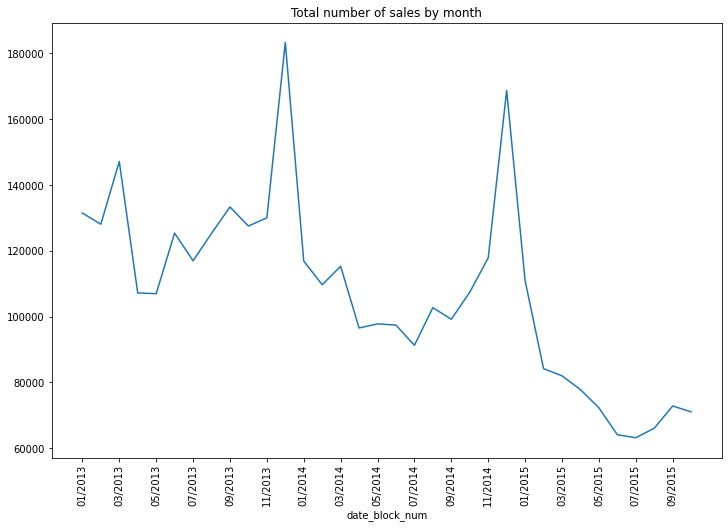

In [ ]:
# convert the dates into datetime
sales_timeseries = sales_train_df.groupby('date_block_num').item_cnt_day.sum()
sales_train_df.date = [datetime.strptime(a,'%d.%m.%Y') for a in sales_train_df.date]
dates = sales_train_df.groupby('date_block_num').date.min()
date_str = np.array([d.strftime('%m/%Y') for d in dates])
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax = sales_timeseries.plot()
ax.xaxis.axes.set_xticks(range(0,len(dates),2));
ax.xaxis.axes.set_xticklabels(date_str[0:-1:2],rotation=90);
ax.set_title('Total number of sales by month');

  There is clearly seasonality in the data, with sales peaking at end of every year. There also seems to be a long term trend. For this reason I will include lagged values of all the key features. 



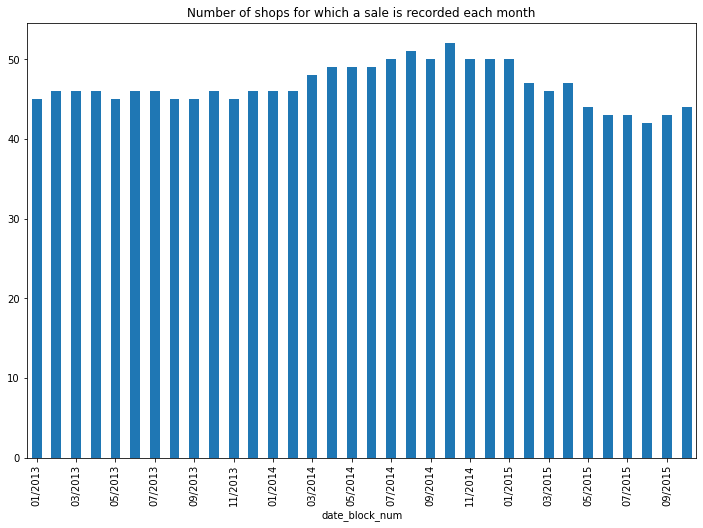

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
sales_train_df.groupby('date_block_num').shop_id.nunique().plot(kind='bar');
ax.xaxis.axes.set_xticks(range(0,len(dates),2));
ax.xaxis.axes.set_xticklabels(date_str[0:-1:2],rotation=90);
plt.title('Number of shops for which a sale is recorded each month');

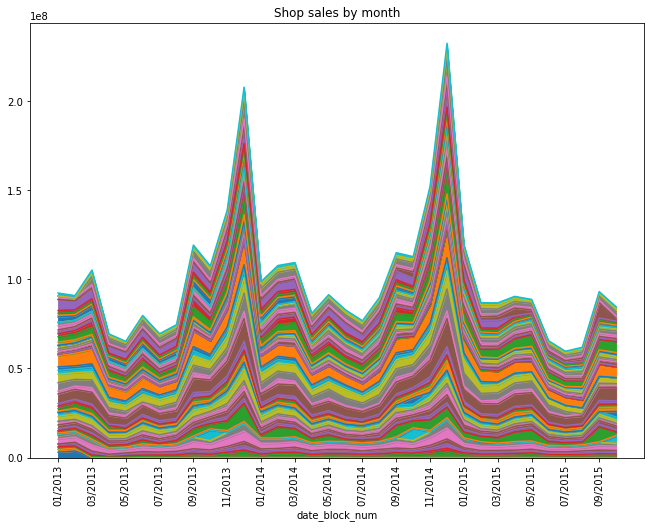

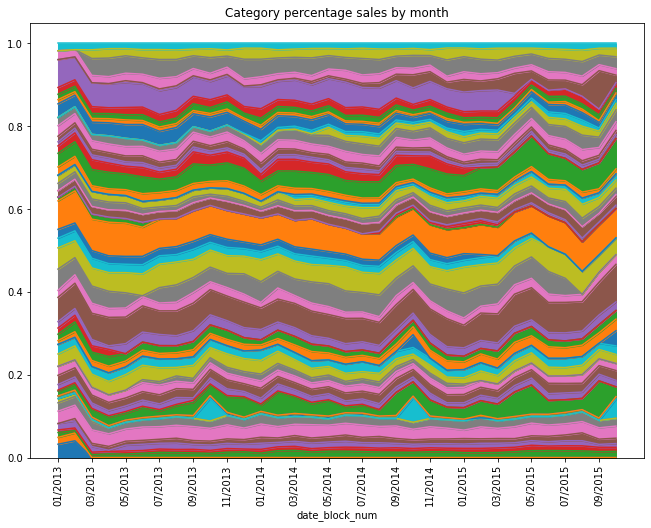

In [ ]:
sales_by_shop = sales_train_df.groupby(['date_block_num','shop_id']).item_value.sum().unstack().fillna(0)
ax = sales_by_shop.plot.area()
ax.get_legend().remove()
fig = plt.gca()
fig.figure.set_size_inches(11,8)
ax.xaxis.axes.set_xticks(range(0,len(dates),2));
ax.xaxis.axes.set_xticklabels(date_str[0:-1:2],rotation=90);
plt.title('Shop sales by month');


percentage_sales_by_shop = sales_by_shop/np.tile(np.sum(sales_by_shop,axis=1),(sales_by_shop.shape[1],1)).transpose()

ax = percentage_sales_by_shop.plot.area()
ax.get_legend().remove()
fig = plt.gca()
fig.figure.set_size_inches(11,8)
ax.xaxis.axes.set_xticks(range(0,len(dates),2));
ax.xaxis.axes.set_xticklabels(date_str[0:-1:2],rotation=90);
plt.title('Category percentage sales by month');



The percentage of the sales that comes from each shop seems to stay relatively constant.

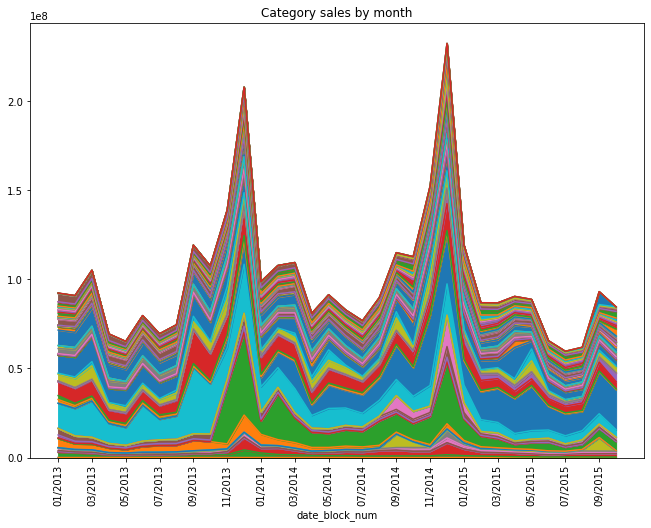

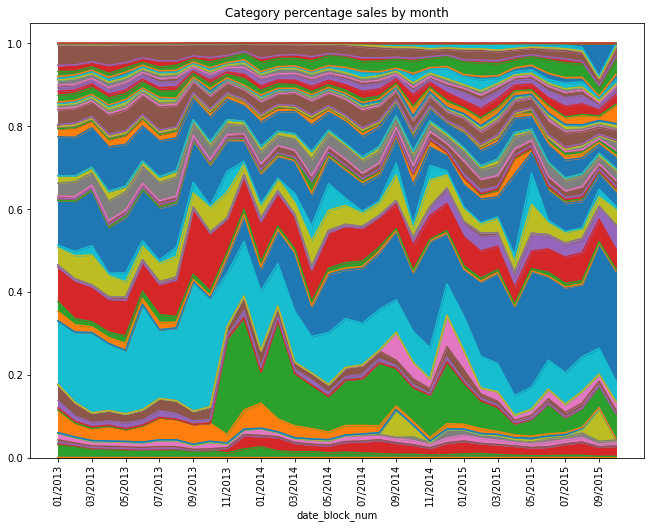

In [ ]:
sales_by_cat = sales_train_df.groupby(['date_block_num','item_category_id']).item_value.sum().unstack().fillna(0)
ax = sales_by_cat.plot.area()
ax.get_legend().remove()
fig = plt.gca()
fig.figure.set_size_inches(11,8)
ax.xaxis.axes.set_xticks(range(0,len(dates),2));
ax.xaxis.axes.set_xticklabels(date_str[0:-1:2],rotation=90);
plt.title('Category sales by month');

percentage_sales_by_cat = sales_by_cat/np.tile(np.sum(sales_by_cat,axis=1),(sales_by_cat.shape[1],1)).transpose()

ax = percentage_sales_by_cat.plot.area()
ax.get_legend().remove()
fig = plt.gca()
fig.figure.set_size_inches(11,8)
ax.xaxis.axes.set_xticks(range(0,len(dates),2));
ax.xaxis.axes.set_xticklabels(date_str[0:-1:2],rotation=90);
plt.title('Category percentage sales by month');


Categories are important - the sales and percentage sales of different categories have long term trends.

10 most expensive items
2934256     41990.0
1962819     42000.0
2934252     42990.0
2934258     42990.0
2934262     42990.0
2934260     42990.0
2771879     49782.0
2294618     50999.0
1180083     59200.0
2163826    307980.0
Name: item_price, dtype: float64
most expensive item is item number 6066


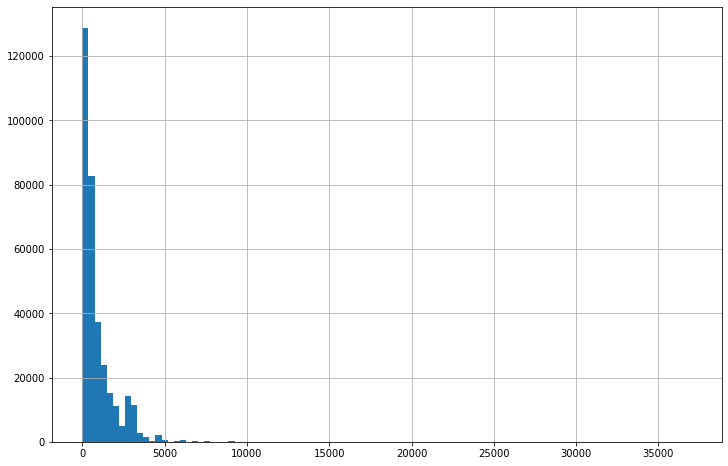

In [ ]:
print('10 most expensive items')
print(sales_train_df.item_price.sort_values()[-10:])
print('most expensive item is item number {}'.format(sales_train_df.loc[2163826,'item_id']))

fig,ax = plt.subplots(1,1,figsize=(12,8))
sales_train_df[sales_train_df.item_id <=np.percentile(sales_train_df.item_price,95)].item_price.hist(bins=100)


There is a very long tail in the item price histogram -  this only show up to the 95th percentile.

# Creating features 
The train-test split is time based - the rows with date_block_num =34 comprise the test set and the private set is a random subset of the test set.

Below I create a dataframe containing all the data.

In [ ]:
# create a single dataframe that we use to generate all features
# create dummy rows for the submission data

# target date_block_num - max(date_block_num)+1
test_df['date_block_num'] = sales_train_df.date_block_num.max()+1
# target date - first day of the target month
last_date = pd.to_datetime(sales_train_df.loc[sales_train_df.date_block_num.argmax()].date,format='%d.%m.%Y')
target_date_year = last_date.year+np.int(np.floor(last_date.month/12))
target_date_month = np.mod(last_date.month,12)+1
target_date_day = 1
test_df['date'] = pd.datetime(target_date_year,target_date_month,target_date_day)

test_df.drop('ID',axis=1)
sales_train_df.date = pd.to_datetime(sales_train_df.date,format='%d.%m.%Y')
train_test_df = pd.concat([sales_train_df,test_df.drop('ID',axis=1)])

#agg_df = pd.merge(train_test_df,items_df.loc[:,['item_id','item_category_id']],\
#                  how='left',left_on=['item_id'],right_on=['item_id'])
agg_df = pd.merge(train_test_df,test_df.loc[:,['item_id','shop_id','ID']],how='left',on=['item_id','shop_id'])
agg_df['item_net'] = agg_df['item_cnt_day']*agg_df['item_price']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  # This is added back by InteractiveShellApp.init_path()


I create a new feature based on the price of the item, dividing the prices of all items in deciles and including one extra bucket for the 99th percentile.

In [ ]:
# look at price to see if it can be used to create a feature
agg_df = agg_df.loc[agg_df.item_price != -1,:]
prices = agg_df.loc[agg_df.date_block_num != 34].item_price.values
prices = prices[prices>0]
prices[::-1].sort()
prices = prices[prices < np.percentile(prices,99)]
edges = np.percentile(prices,range(0,100,10))
edges = np.append(edges,np.percentile(prices,99))

# bin the prices into deciles (and a separate category for prices > 99th percentile )
for i in range(10):
  agg_df.loc[(agg_df.item_price >= edges[i]) & (agg_df.item_price < edges[i+1]),'price_bin']=i

agg_df.loc[agg_df.item_price >= edges[-1],'price_bin']=10
agg_df.loc[agg_df.item_price <= 0,'price_bin']=-1



I have created another new feature based on the words in the category names. I find a list of unique words the list of all categories, I then define a notion of distance between 2 categories based on the lengths of common words. From this we can find the K nearest neighbours of each category and construct features such as the mean sales of each of the nearest categoies.

In the end I did not use these features as they did not improve the results but the code is shown below.


In [ ]:
# get a list of all the words that appear in item categories
word_list = []
for _str in item_categories_df.item_category_name:
    word_list = word_list + _str.split()
    

word_counts = pd.value_counts(word_list)
word_counts = word_counts[word_counts .index !='-']
word_counts = word_counts[word_counts.values>=3]

# create a one hot encoding of the most common words in the category names
word_featue_oh = np.zeros([item_categories_df.item_category_name.shape[0]\
                           ,word_counts.shape[0]])
cat_name = item_categories_df.item_category_name[0]
row_n = 0
for cat_name  in item_categories_df.item_category_name:
    word_featue_oh[row_n,:]  = word_counts.index.isin(cat_name.split()).astype(int)
    row_n = row_n+1

# for each word this says how many items were sold whose category name contained that word
word_feature_encoded = np.dot(agg_df.groupby('item_category_id')\
                              ['item_cnt_day'].sum().values,word_featue_oh)



word_sales = np.dot(agg_df.groupby('item_category_id')['item_cnt_day'].sum().values,\
       word_featue_oh )

# get a list of all the words that appear in item names
item_word_list = []
for _str in items_df.item_name:
    word_list = word_list + _str.split()

item_word_count = pd.value_counts(item_word_list)


def name_distance(name1,name2):
    if name1 == name2:
      return 0
    split1 = name1.split()
    split2 = name2.split()
    intersect = [value for value in split1  if value in split2]     
    if intersect == []:
        return np.inf
    else: 
        # the inverse of the sum of the lenghts of all common words
        return 1/(sum(len(x) for x in intersect))

items_df = pd.merge(items_df,item_categories_df[['item_category_name','item_category_id']],on='item_category_id',how='left')
distance = []
name1 = item_categories_df.item_category_name[0]
for i,name2 in enumerate(item_categories_df.item_category_name):
    distance.append(name_distance(name1,name2))

from sklearn.neighbors import NearestNeighbors

NN = NearestNeighbors(n_neighbors=5,
                      algorithm='auto',
                      metric=name_distance)



As mentioned above, training only on the examples in the train set won't work since we need empty examples to train on. So I am training only on the item-shop pairs that are in the test set. In my training set there is a row for every test item-shop pair and every date_block_num. The target is set to 0 whenever the relevant (item,shop,date_block_num)-tuple is not in sales_train_df. 
  For a given example of a item, shop, date_block tuple, I include the net sales of that item/shop pair in the last 1, 6 and 12 months as well as the sales in the same month 1 year ago.
  Note that is the same as mean-encoding this category.
  Similarly, I include the net sales of that item in all shops in the last 1, 6 and 12 months and 1 year ago, and I do likewise for the item_category and price_bin. Finally I include a categorical variable for the month of the year - again I mean encode this variable. I clip the target to lie between 0 and 20.


In [ ]:
# define a function to generate features
def generate_features(agg_df, target_pairs, target_month_blocks):
    # it isn't feasible to train on every shop_id and item_id pair so I will just
    # train on the ones in the test set
    template_df = target_pairs
    template_df = pd.merge(template_df,\
             agg_df.groupby(['item_id','shop_id','item_category_id']).sum().reset_index().loc[:,['item_id','shop_id','item_category_id','price_bin']],\
             how='left',on=['item_id','shop_id'])

    features_all = pd.DataFrame()  
    for target_month in target_month_blocks:
        # create some features
        # i will use last month sales, average of last 12 months sales,
        # sales from target month last year

        # create a dataframe which has a row for every item_id, shop_id pair which appear in the test set
        features = template_df
        features['date_block_num'] = target_month

        ########################################################################
        ############### aggregate by (item_id,shop_id) #########################
        ########################################################################

        # prev months sales for this (item_id,shop_id) pair
        prev_month_sales = agg_df[agg_df.date_block_num==(target_month-1)].\
            groupby(['item_id','shop_id'])['item_cnt_day'].sum().reset_index()
        prev_month_sales.rename(columns={'item_cnt_day':'prev_month_sales'},inplace=True)
        prev_month_sales.prev_month_sales.fillna(0,inplace=True)
        features = pd.merge(features, prev_month_sales, how = 'left',on = ['item_id','shop_id'])

        # prev 6 months sales for this (item_id,shop_id) pair
        prev_6_month_sales = agg_df[agg_df.date_block_num.between(target_month-7,target_month-1)].\
            groupby(['item_id','shop_id'])['item_cnt_day'].sum().reset_index()
        prev_6_month_sales.rename(columns={'item_cnt_day':'prev_6_month_sales'},inplace=True)
        prev_6_month_sales.prev_6_month_sales.fillna(0,inplace=True)
        features = pd.merge(features,prev_6_month_sales, how = 'left',on = ['item_id','shop_id'])

        # prev 12 months sales for this (item_id,shop_id) pair
        prev_12_month_sales = agg_df[agg_df.date_block_num.between(target_month-13,target_month-1)].\
            groupby(['item_id','shop_id'])['item_cnt_day'].sum().reset_index()
        prev_12_month_sales.rename(columns={'item_cnt_day':'prev_12_month_sales'},inplace=True)
        prev_12_month_sales.prev_12_month_sales.fillna(0,inplace=True)
        features = pd.merge(features,prev_12_month_sales, how = 'left',on = ['item_id','shop_id'])
        
        # sales of same month last year for this (item_id,shop_id) pair
        last_year_sales = agg_df[agg_df.date_block_num == target_month-12].\
          groupby(['item_id','shop_id'])['item_cnt_day'].sum().reset_index()
        last_year_sales.rename(columns={'item_cnt_day':'last_year_sales'},inplace=True)
        last_year_sales.last_year_sales.fillna(0,inplace=True)
        features = pd.merge(features,last_year_sales, how = 'left',on = ['item_id','shop_id'])
        
         ########################################################################
        ################### aggregate by item_id ###############################
        ########################################################################

        # total sales of this item_id for last month
        prev_month_item_sales = agg_df[agg_df.date_block_num == target_month-1].\
          groupby('item_id')['item_cnt_day'].sum().reset_index()
        prev_month_item_sales.rename(columns={'item_cnt_day':'prev_month_item_sales'},inplace=True)
        prev_month_item_sales.prev_month_item_sales.fillna(0,inplace=True)
        features = pd.merge(features,prev_month_item_sales, how = 'left',on = ['item_id'])

        # prev 6 months sales for this item_id
        prev_6_month_sales = agg_df[agg_df.date_block_num.between(target_month-7,target_month-1)].\
            groupby('item_id')['item_cnt_day'].sum().reset_index()
        prev_6_month_sales.rename(columns={'item_cnt_day':'prev_6_month_item_sales'},inplace=True)
        prev_6_month_sales.prev_6_month_item_sales.fillna(0,inplace=True)
        features = pd.merge(features,prev_6_month_sales, how = 'left',on = ['item_id'])

        # prev 12 months sales for this item_id
        prev_12_month_sales = agg_df[agg_df.date_block_num.between(target_month-13,target_month-1)].\
            groupby(['item_id'])['item_cnt_day'].sum().reset_index()
        prev_12_month_sales.rename(columns={'item_cnt_day':'prev_12_month_item_sales'},inplace=True)
        prev_12_month_sales.prev_12_month_item_sales.fillna(0,inplace=True)
        features = pd.merge(features,prev_12_month_sales, how = 'left',on = ['item_id'])
        
        # sales of same month last year for this item_id
        last_year_sales = agg_df[agg_df.date_block_num == target_month-12].\
          groupby(['item_id'])['item_cnt_day'].sum().reset_index()
        last_year_sales.rename(columns={'item_cnt_day':'last_year_item_sales'},inplace=True)
        last_year_sales.last_year_item_sales.fillna(0,inplace=True)
        features = pd.merge(features,last_year_sales, how = 'left',on = ['item_id'])

        ########################################################################
        ################### aggregate by shop_id ###############################
        ########################################################################

        # total sales in this shop for last month
        prev_month_shop_sales = agg_df[agg_df.date_block_num == target_month-1].\
          groupby('shop_id')['item_cnt_day'].sum().reset_index()
        prev_month_shop_sales.rename(columns={'item_cnt_day':'prev_month_shop_sales'},inplace=True)
        prev_month_shop_sales.prev_month_shop_sales.fillna(0,inplace=True)
        features = pd.merge(features,prev_month_shop_sales, how = 'left',on = ['shop_id'])
                
        # prev 6 months sales for this shop_id
        prev_6_month_sales = agg_df[agg_df.date_block_num.between(target_month-7,target_month-1)].\
            groupby('shop_id')['item_cnt_day'].sum().reset_index()
        prev_6_month_sales.rename(columns={'item_cnt_day':'prev_6_month_shop_sales'},inplace=True)
        prev_6_month_sales.prev_6_month_shop_sales.fillna(0,inplace=True)
        features = pd.merge(features,prev_6_month_sales, how = 'left',on = ['shop_id'])

        # prev 12 months sales for this shop_id
        prev_12_month_sales = agg_df[agg_df.date_block_num.between(target_month-13,target_month-1)].\
            groupby(['shop_id'])['item_cnt_day'].sum().reset_index()
        prev_12_month_sales.rename(columns={'item_cnt_day':'prev_12_month_shop_sales'},inplace=True)
        prev_12_month_sales.prev_12_month_shop_sales.fillna(0,inplace=True)
        features = pd.merge(features,prev_12_month_sales, how = 'left',on = ['shop_id'])
        
        # sales of same month last year for this shop_id
        last_year_sales = agg_df[agg_df.date_block_num == target_month-12].\
          groupby(['shop_id'])['item_cnt_day'].sum().reset_index()
        last_year_sales.rename(columns={'item_cnt_day':'last_year_shop_sales'},inplace=True)
        last_year_sales.last_year_shop_sales.fillna(0,inplace=True)
        features = pd.merge(features,last_year_sales, how = 'left',on = ['shop_id'])

        ########################################################################
        ################ aggregate by item category ############################
        ########################################################################

        # total sales of this item category for last month
        prev_month_category_sales = agg_df[agg_df.date_block_num == target_month-1].\
          groupby('item_category_id')['item_cnt_day'].sum().reset_index()
        prev_month_category_sales.rename(columns={'item_cnt_day':'prev_month_category_sales'},inplace=True)
        prev_month_category_sales.prev_month_category_sales.fillna(0,inplace=True)
        features = pd.merge(features,prev_month_category_sales, how = 'left',on = ['item_category_id'])

        # prev 6 months sales for this category_id
        prev_6_month_sales = agg_df[agg_df.date_block_num.between(target_month-7,target_month-1)].\
            groupby('item_category_id')['item_cnt_day'].sum().reset_index()
        prev_6_month_sales.rename(columns={'item_cnt_day':'prev_6_month_category_sales'},inplace=True)
        prev_6_month_sales.prev_6_month_category_sales.fillna(0,inplace=True)
        features = pd.merge(features,prev_6_month_sales, how = 'left',on = ['item_category_id'])

        # prev 12 months sales for this shop_id
        prev_12_month_sales = agg_df[agg_df.date_block_num.between(target_month-13,target_month-1)].\
            groupby(['item_category_id'])['item_cnt_day'].sum().reset_index()
        prev_12_month_sales.rename(columns={'item_cnt_day':'prev_12_month_category_sales'},inplace=True)
        prev_12_month_sales.prev_12_month_category_sales.fillna(0,inplace=True)
        features = pd.merge(features,prev_12_month_sales, how = 'left',on = ['item_category_id'])
        
        # sales of same month last year for this shop_id
        last_year_sales = agg_df[agg_df.date_block_num == target_month-12].\
          groupby(['item_category_id'])['item_cnt_day'].sum().reset_index()
        last_year_sales.rename(columns={'item_cnt_day':'last_year_category_sales'},inplace=True)
        last_year_sales.last_year_category_sales.fillna(0,inplace=True)
        features = pd.merge(features,last_year_sales, how = 'left',on = ['item_category_id'])
  
        ########################################################################
        ################# aggregate by price block #############################
        ########################################################################

        # total sales of this price block for last month
        prev_month_price_cat_sales = agg_df[agg_df.date_block_num == target_month-1].\
          groupby('price_bin')['item_cnt_day'].sum().reset_index()
        prev_month_price_cat_sales.rename(columns={'item_cnt_day':'prev_month_price_cat_sales'},inplace=True)
        prev_month_price_cat_sales.prev_month_price_cat_sales.fillna(0,inplace=True)
        features = pd.merge(features,prev_month_price_cat_sales, how = 'left',on = ['price_bin'])

        # prev 6 months sales for this category_id
        prev_6_month_sales = agg_df[agg_df.date_block_num.between(target_month-7,target_month-1)].\
            groupby('price_bin')['item_cnt_day'].sum().reset_index()
        prev_6_month_sales.rename(columns={'item_cnt_day':'prev_6_month_price_cat_sales'},inplace=True)
        prev_6_month_sales.prev_6_month_price_cat_sales.fillna(0,inplace=True)
        features = pd.merge(features,prev_6_month_sales, how = 'left',on = ['price_bin'])

        # prev 12 months sales for this shop_id
        prev_12_month_sales = agg_df[agg_df.date_block_num.between(target_month-13,target_month-1)].\
            groupby(['price_bin'])['item_cnt_day'].sum().reset_index()
        prev_12_month_sales.rename(columns={'item_cnt_day':'prev_12_month_price_cat_sales'},inplace=True)
        prev_12_month_sales.prev_12_month_price_cat_sales.fillna(0,inplace=True)
        features = pd.merge(features,prev_12_month_sales, how = 'left',on = ['price_bin'])
        
        # sales of same month last year for this shop_id
        last_year_sales = agg_df[agg_df.date_block_num == target_month-12].\
          groupby(['price_bin'])['item_cnt_day'].sum().reset_index()
        last_year_sales.rename(columns={'item_cnt_day':'last_year_price_cat_sales'},inplace=True)
        last_year_sales.last_year_price_cat_sales.fillna(0,inplace=True)
        features = pd.merge(features,last_year_sales, how = 'left',on = ['price_bin'])

        # categorical variable for the target month
        month_category = agg_df.loc[agg_df.loc[(agg_df.date_block_num == target_month)].first_valid_index()].date.month
        features['target_month_category'] = month_category

        # target
        target = agg_df[agg_df.date_block_num==target_month].\
            groupby(['item_id','shop_id'])['item_cnt_day'].sum().reset_index()
        target.rename(columns={'item_cnt_day':'target'},inplace=True)
        target.target = target.target.clip(0,20)
        features = pd.merge(features, target, how = 'left',on = ['item_id','shop_id'])


        features_all = pd.concat([features_all,features])
    features_all.fillna(0,inplace=True)
    return features_all

I create a DataFrame called X_all which contains all the training rows. There are also rows for each of the test examples with the target set to 0 (these are just placeholders).

In [ ]:
start_month = 13
end_month = 34
month_blocks = np.arange(start_month,end_month+1)
target_pairs = test_df.loc[:,['item_id','shop_id']]
X_all = generate_features(agg_df, target_pairs=target_pairs, target_month_blocks=month_blocks)
X_all.fillna(0,inplace=True)

In [ ]:
fit_cols = X_all.columns[[s not in ['date_block_num','target'] for s in X_all.columns]]
fit_cols = fit_cols[4:]
print(fit_cols)


Index(['prev_month_sales', 'prev_6_month_sales', 'prev_12_month_sales',
       'last_year_sales', 'prev_month_item_sales', 'prev_6_month_item_sales',
       'prev_12_month_item_sales', 'last_year_item_sales',
       'prev_month_shop_sales', 'prev_6_month_shop_sales',
       'prev_12_month_shop_sales', 'last_year_shop_sales',
       'prev_month_category_sales', 'prev_6_month_category_sales',
       'prev_12_month_category_sales', 'last_year_category_sales',
       'prev_month_price_cat_sales', 'prev_6_month_price_cat_sales',
       'prev_12_month_price_cat_sales', 'last_year_price_cat_sales',
       'target_month_category'],
      dtype='object')


In total there are now 21 trainable features. I randomly split the data and train on a lightGBM model to determine the most important features.


[1]	valid_0's rmse: 1.08875	valid_1's rmse: 1.08787
[2]	valid_0's rmse: 1.07724	valid_1's rmse: 1.0765
[3]	valid_0's rmse: 1.0633	valid_1's rmse: 1.06252
[4]	valid_0's rmse: 1.05004	valid_1's rmse: 1.04929
[5]	valid_0's rmse: 1.03743	valid_1's rmse: 1.03664
[6]	valid_0's rmse: 1.02721	valid_1's rmse: 1.02652
[7]	valid_0's rmse: 1.01573	valid_1's rmse: 1.01508
[8]	valid_0's rmse: 1.00468	valid_1's rmse: 1.00403
[9]	valid_0's rmse: 0.994088	valid_1's rmse: 0.993413
[10]	valid_0's rmse: 0.985336	valid_1's rmse: 0.984737
[11]	valid_0's rmse: 0.977125	valid_1's rmse: 0.976613
[12]	valid_0's rmse: 0.967852	valid_1's rmse: 0.967399
[13]	valid_0's rmse: 0.959788	valid_1's rmse: 0.959302
[14]	valid_0's rmse: 0.95214	valid_1's rmse: 0.951626
[15]	valid_0's rmse: 0.945415	valid_1's rmse: 0.945007
[16]	valid_0's rmse: 0.939143	valid_1's rmse: 0.938728
[17]	valid_0's rmse: 0.93146	valid_1's rmse: 0.931046
[18]	valid_0's rmse: 0.924104	valid_1's rmse: 0.923665
[19]	valid_0's rmse: 0.917052	valid_1's

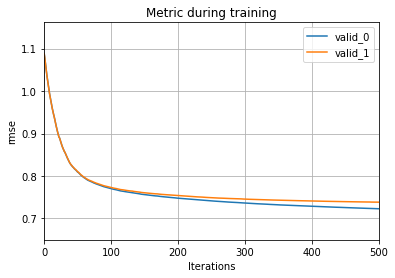

In [ ]:
  # random split of train data
  X_train_val = X_all.loc[X_all.date_block_num.between(10,33),:]
  Y_train_val = X_all.loc[X_all.date_block_num.between(10,33),'target']
  X_train, X_val, Y_train, Y_val =  train_test_split(X_train_val, Y_train_val, \
  test_size = 0.2, random_state = 123)
  del X_train_val, Y_train_val

  lgb_params = {
               'feature_fraction': 0.5,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.5, 
               'learning_rate': 0.03,
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1
              }
  evals_result1 = {}
  lgb_model_1 = lgb.train(lgb_params, lgb.Dataset(X_train.loc[:,fit_cols], label=Y_train), 500,
                  valid_sets = [lgb.Dataset(X_train.loc[:,fit_cols], label=Y_train),
                                lgb.Dataset(X_val.loc[:,fit_cols], label=Y_val)],
                          evals_result = evals_result1)
  lgb.plot_metric(evals_result1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


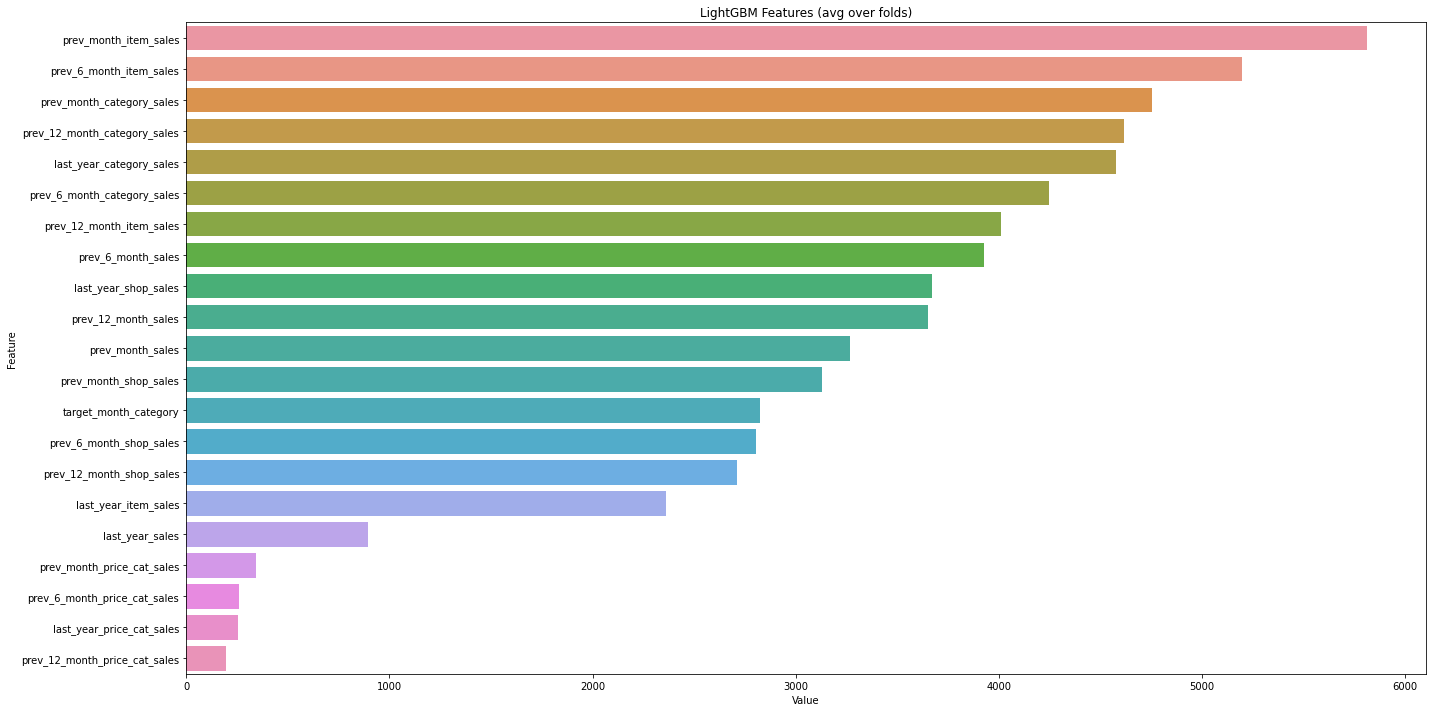

<Figure size 432x288 with 0 Axes>

In [ ]:
# now plot feature importances
import matplotlib.pyplot as plt
import seaborn as sns
#lgb.importance(model, percentage = True)
feat_imp = lgb_model_1.feature_importance()
feature_imp = pd.DataFrame(sorted(zip(feat_imp,fit_cols)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [ ]:
# I discard the 5 least important
fit_cols_imp = feature_imp.loc[5:,'Feature'].values

# Model Fitting
  Now I will fit 4 models on the above features on the Data up to month block 30 using these features. The models are Linear Regression, LightGBM, Neural Net and Random Forest. The data from months 31,32 and 33 will be used as a validation set. The predictions from each model on validation is then used as a feature for a linear regression on validation set (stacking step).


In [ ]:
  # time based split
  X_train = X_all.loc[X_all.date_block_num.between(10,30),:]
  Y_train = X_all.loc[X_all.date_block_num.between(10,30),'target']
  X_val = X_all.loc[X_all.date_block_num.between(31,33),:]
  Y_val = X_all.loc[X_all.date_block_num.between(31,33),'target']

  X_test =  X_all.loc[X_all.date_block_num.between(34,34),:]

Model number 1: Linear regression

RMSE for linear regression model = 0.972


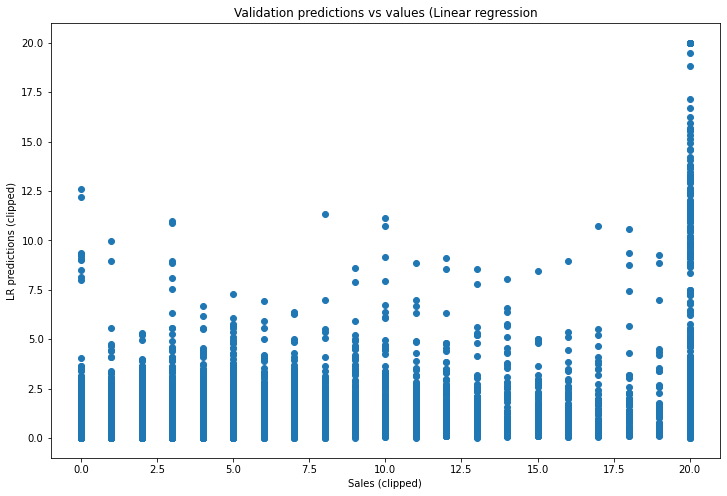

In [ ]:
# linear regression
lr_model = LinearRegression()
lr_model.fit(X_train.loc[:,fit_cols_imp], Y_train)
lr_val_features = lr_model.predict(X_val.loc[:,fit_cols_imp])
lr_val_features = lr_val_features.clip(0,20)
lr_test_features = lr_model.predict(X_test.loc[:,fit_cols_imp])
lr_test_features = lr_test_features.clip(0,20)
rmse_lr_val = np.sqrt(np.mean((Y_val - lr_val_features)**2))

# submit on test
X_test.target = lr_test_features
submission_df = pd.merge(test_df,X_test.loc[:,['item_id','shop_id','target']],how='left',on=['item_id','shop_id'])
submission_df = submission_df.loc[:,['ID','target']]
submission_df.rename(columns={'target':'item_cnt_month'},inplace = True)
submission_df
submission_df.to_csv('submission_lin_reg_23_6.csv',index=False)

#Your public and private LB scores are: 1.246914 and 1.122517.
print('RMSE for linear regression model = {:.3f}'.format(rmse_lr_val))
fig,ax= plt.subplots(1,1,figsize=(12,8))
plt.scatter(Y_val,lr_val_features);
plt.title('Validation predictions vs values (Linear regression');
ax.set_xlabel('Sales (clipped)');
ax.set_ylabel('LR predictions (clipped)');

Model number 2: Light GBM.
The model starts overfitting after about 175 iters. 

Validation RMSE for light GBM model = 0.776


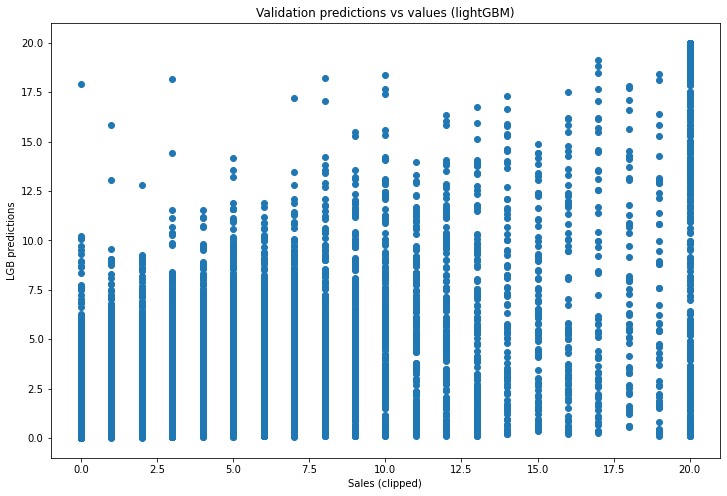

In [ ]:
lgb_params = {
               'feature_fraction': 0.5,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.5, 
               'learning_rate': 0.03,
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1
              }
evals_result2 = {}
lgb_model_2 = lgb.train(lgb_params, lgb.Dataset(X_train.loc[:,fit_cols_imp], label=Y_train), 200,
                valid_sets = [lgb.Dataset(X_train.loc[:,fit_cols_imp], label=Y_train),
                              lgb.Dataset(X_val.loc[:,fit_cols_imp], label=Y_val)],
                        evals_result = evals_result2)
lgb.plot_metric(evals_result2)

lgbm_val_features = lgb_model_2.predict(X_val.loc[:,fit_cols_imp])
lgbm_val_features = lgbm_val_features.clip(0,20)
lgbm_test_features = lgb_model_2.predict(X_test.loc[:,fit_cols_imp])
lgbm_test_features = lgbm_test_features.clip(0,20)
rmse_lgbm_val = np.sqrt(np.mean((Y_val - lgbm_val_features)**2))


# submit on test
X_test.target = lgbm_test_features
submission_df = pd.merge(test_df,X_test.loc[:,['item_id','shop_id','target']],how='left',on=['item_id','shop_id'])
submission_df = submission_df.loc[:,['ID','target']]
submission_df.rename(columns={'target':'item_cnt_month'},inplace = True)
submission_df
submission_df.to_csv('submission_lgbm_23_6.csv',index=False)

#Your public and private LB scores are: 1.006702 and 1.003298.
print('Validation RMSE for light GBM model = {:.3f}'.format(rmse_lgbm_val))
fig,ax= plt.subplots(1,1,figsize=(12,8))
plt.scatter(Y_val,lgbm_val_features)
plt.title('Validation predictions vs values (lightGBM)');
ax.set_xlabel('Sales (clipped)');
ax.set_ylabel('LGB predictions');

Model number 3: Random Forest

Validation RMSE for random forest model = 0.857


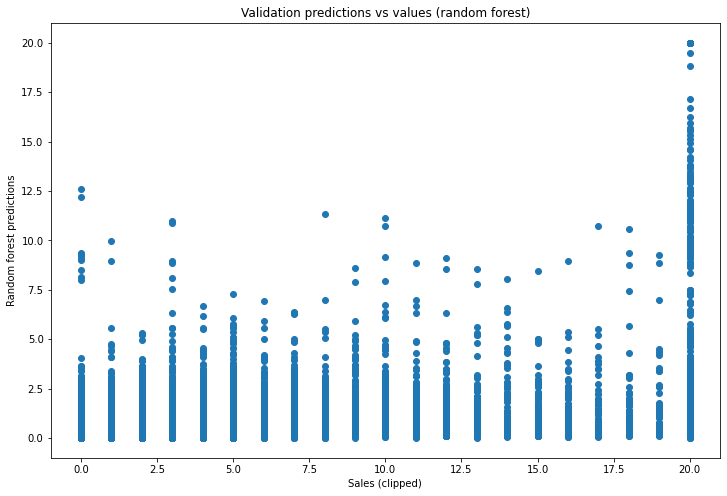

In [ ]:
# random forest
rf_model = RandomForestRegressor(n_estimators = 50, criterion='mse', random_state = 42,verbose=1,max_depth=5,n_jobs=-1)
# Train the model on training data
rf_model.fit(X_train.loc[:,fit_cols_imp], Y_train)

rf_val_features = rf_model.predict(X_val.loc[:,fit_cols_imp])
rf_val_features = rf_val_features.clip(0,20)
rf_test_features = rf_model.predict(X_test.loc[:,fit_cols_imp])
rf_test_features = rf_test_features.clip(0,20)
rmse_rf = np.sqrt(np.mean((rf_val_features - Y_val.values)**2))

# submit on test
X_test.target = rf_test_features
submission_df = pd.merge(test_df,X_test.loc[:,['item_id','shop_id','target']],how='left',on=['item_id','shop_id'])
submission_df = submission_df.loc[:,['ID','target']]
submission_df.rename(columns={'target':'item_cnt_month'},inplace = True)
submission_df
submission_df.to_csv('submission_rf_23_6.csv',index=False)

#Your public and private LB scores are: 1.024358 and 1.020843.
print('Validation RMSE for random forest model = {:.3f}'.format(rmse_rf))
fig,ax= plt.subplots(1,1,figsize=(12,8))
plt.scatter(Y_val,lr_val_features)
plt.title('Validation predictions vs values (random forest)');
ax.set_xlabel('Sales (clipped)');
ax.set_ylabel('Random forest predictions');

Model number 4: Neural Net - fit for 5 epochs





Validation RMSE for neural network model = 0.879


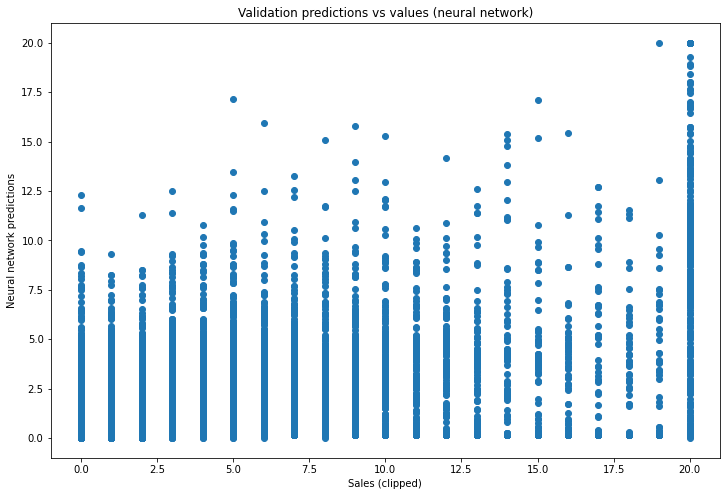

In [ ]:
# neural net
nn_model = Sequential()
nn_model.add(Dense(20, input_dim=fit_cols_imp.shape[0], kernel_initializer='normal', activation='relu'))
nn_model.add(Dense(10, input_dim=20, kernel_initializer='normal', activation='relu'))
nn_model.add(Dense(8, input_dim=10, kernel_initializer='normal', activation='relu'))
nn_model.add(Dense(1, kernel_initializer='normal'))
# Compile model
nn_model.compile(loss='mean_squared_error', optimizer='adam')
nn_model.fit(X_train.loc[:,fit_cols_imp],Y_train,batch_size=64,epochs=5, validation_data=(X_val.loc[:,fit_cols_imp], Y_val))

nn_val_features = nn_model.predict(X_val.loc[:,fit_cols_imp])
nn_val_features = nn_val_features.reshape([nn_val_features.shape[0]])
nn_val_features = nn_val_features.clip(0,20)
nn_test_features = nn_model.predict(X_test.loc[:,fit_cols_imp])
nn_test_features = nn_test_features.reshape([nn_test_features.shape[0]])
nn_test_features = nn_test_features.clip(0,20)
rmse_nn = np.sqrt(np.mean((nn_val_features-Y_val)**2))

# submit on test
X_test.target = nn_test_features
submission_df = pd.merge(test_df,X_test.loc[:,['item_id','shop_id','target']],how='left',on=['item_id','shop_id'])
submission_df = submission_df.loc[:,['ID','target']]
submission_df.rename(columns={'target':'item_cnt_month'},inplace = True)
submission_df
submission_df.to_csv('submission_nn_23_6.csv',index=False)

#Your public and private LB scores are: 1.067357 and 1.071933
print('Validation RMSE for neural network model = {:.3f}'.format(rmse_nn))
fig,ax= plt.subplots(1,1,figsize=(12,8))
plt.scatter(Y_val,nn_val_features)
plt.title('Validation predictions vs values (neural network)');
ax.set_xlabel('Sales (clipped)');
ax.set_ylabel('Neural network predictions');


# Ensemble model
Next I will fit a linear regression of these 4 "features" (ie the output of these 4 models) on validation (ie months 31-33)

0.8343311669297943


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Validation RMSE for linear regression ensemble model = 0.879


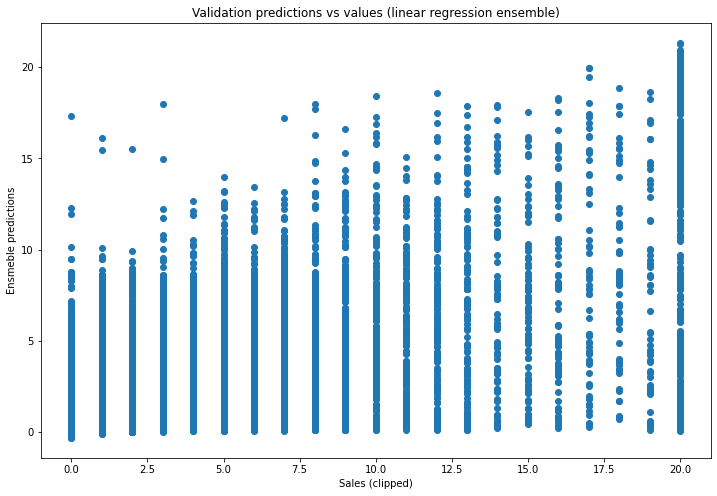

In [ ]:
stage_2_df = pd.DataFrame({'lr':lr_val_features,
                           'lgbm':lgbm_val_features,
                           'rf':rf_val_features,
                           'nn':nn_val_features.transpose()})
stage_2_test_df = pd.DataFrame({'lr':lr_test_features,
                                'lgbm':lgbm_test_features,
                                'rf':rf_test_features,
                                'nn':nn_test_features.transpose()})
lr_model_2 = LinearRegression()
lr_model_2.fit(stage_2_df, Y_val)

lr_ensemble_val_preds = lr_model_2.predict(stage_2_df)
rmse_lr_val_2 = np.sqrt(np.mean((Y_val - lr_val_preds)**2))
print(rmse_lr_val_2)

# submit on test
lr_test_preds = lr_model_2.predict(stage_2_test_df)
X_test.target = lr_test_preds
submission_df = pd.merge(test_df,X_test.loc[:,['item_id','shop_id','target']],how='left',on=['item_id','shop_id'])
submission_df = submission_df.loc[:,['ID','target']]
submission_df.rename(columns={'target':'item_cnt_month'},inplace = True)
submission_df
submission_df.to_csv('submission_stacked_23_6.csv',index=False)

#Your public and private LB scores are: 1.006702 and 1.003298.
print('Validation RMSE for linear regression ensemble model = {:.3f}'.format(rmse_nn))
fig,ax= plt.subplots(1,1,figsize=(12,8))
plt.scatter(Y_val,lr_ensemble_val_preds)
plt.title('Validation predictions vs values (linear regression ensemble)');
ax.set_xlabel('Sales (clipped)');
ax.set_ylabel('Ensmeble predictions');


Final step - train all the 4 models again as above but this time on ALL the data, combine using the stage 2 linear regression model and this will be my final submission.


In [ ]:
# submission split
X_train = X_all.loc[X_all.date_block_num.between(10,33),:]
Y_train = X_all.loc[X_all.date_block_num.between(10,33),'target']



Linear regression submission

In [ ]:
# linear regression
lr_model_sub = LinearRegression()
lr_model_sub.fit(X_train.loc[:,fit_cols_imp], Y_train)
lr_test_features_sub = lr_model_sub.predict(X_test.loc[:,fit_cols_imp])
lr_test_features_sub = lr_test_features_sub.clip(0,20)

# submit on test
X_test.target = lr_test_features_sub
submission_df = pd.merge(test_df,X_test.loc[:,['item_id','shop_id','target']],how='left',on=['item_id','shop_id'])
submission_df = submission_df.loc[:,['ID','target']]
submission_df.rename(columns={'target':'item_cnt_month'},inplace = True)
submission_df
submission_df.to_csv('submission_final_lr_26_6.csv',index=False)

#Your public and private LB scores are: 1.106389 and 1.110033.


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Light GBM submission

In [ ]:
lgb_params = {
               'feature_fraction': 0.5,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.5, 
               'learning_rate': 0.03,
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1
              }
# 175 iterations
lgb_model_2_sub = lgb.train(lgb_params, lgb.Dataset(X_train.loc[:,fit_cols_imp], label=Y_train), 175)

lgbm_test_features_sub = lgb_model_2_sub.predict(X_test.loc[:,fit_cols_imp])
lgbm_test_features_sub = lgbm_test_features_sub.clip(0,20)

# submit on test
X_test.target = lgbm_test_features_sub
submission_df = pd.merge(test_df,X_test.loc[:,['item_id','shop_id','target']],how='left',on=['item_id','shop_id'])
submission_df = submission_df.loc[:,['ID','target']]
submission_df.rename(columns={'target':'item_cnt_month'},inplace = True)
submission_df
submission_df.to_csv('submission_final_lgbm_26_6.csv',index=False)

#Your public and private LB scores are: 1.071105 and 1.069878.


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Random forest submission

In [ ]:
# random forest
rf_model = RandomForestRegressor(n_estimators = 50, criterion='mse', random_state = 42,verbose=1,max_depth=5,n_jobs=1)
# Train the model on training data
rf_model.fit(X_train.loc[:,fit_cols_imp], Y_train)

rf_test_features_sub = rf_model.predict(X_test.loc[:,fit_cols_imp])
rf_test_features_sub = rf_test_features_sub.clip(0,20)

# submit on test
X_test.target = rf_test_features_sub
submission_df = pd.merge(test_df,X_test.loc[:,['item_id','shop_id','target']],how='left',on=['item_id','shop_id'])
submission_df = submission_df.loc[:,['ID','target']]
submission_df.rename(columns={'target':'item_cnt_month'},inplace = True)
submission_df
submission_df.to_csv('submission_final_rf_26_6.csv',index=False)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 10.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Neural net submission

In [ ]:
# neural net
nn_model = Sequential()
nn_model.add(Dense(20, input_dim=fit_cols_imp.shape[0], kernel_initializer='normal', activation='relu'))
nn_model.add(Dense(10, input_dim=20, kernel_initializer='normal', activation='relu'))
nn_model.add(Dense(8, input_dim=10, kernel_initializer='normal', activation='relu'))
nn_model.add(Dense(1, kernel_initializer='normal'))
# Compile model
nn_model.compile(loss='mean_squared_error', optimizer='adam')
nn_model.fit(X_train.loc[:,fit_cols_imp],Y_train,batch_size=64,epochs=5, validation_data=(X_val.loc[:,fit_cols_imp], Y_val))

nn_test_features_sub = nn_model.predict(X_test.loc[:,fit_cols_imp])
nn_test_features_sub = nn_test_features_sub.reshape([nn_test_features.shape[0]])

# submit on test
X_test.target = nn_test_features_sub
submission_df = pd.merge(test_df,X_test.loc[:,['item_id','shop_id','target']],how='left',on=['item_id','shop_id'])
submission_df = submission_df.loc[:,['ID','target']]
submission_df.rename(columns={'target':'item_cnt_month'},inplace = True)
submission_df
submission_df.to_csv('submission_final_lnn_26_6.csv',index=False)

#Your public and private LB scores are: 1.071105 and 1.069878.



Epoch 1/5
70285/70285 [==============================] - 75s 1ms/step - loss: 0.8678 - val_loss: 0.7930
Epoch 2/5
70285/70285 [==============================] - 73s 1ms/step - loss: 0.7957 - val_loss: 0.7788
Epoch 3/5
70285/70285 [==============================] - 73s 1ms/step - loss: 0.7774 - val_loss: 0.7969
Epoch 4/5
70285/70285 [==============================] - 73s 1ms/step - loss: 0.7746 - val_loss: 0.7741
Epoch 5/5
70285/70285 [==============================] - 73s 1ms/step - loss: 0.7610 - val_loss: 0.7997


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Now we combine all of the above for the final final submission.

In [ ]:
stage_2_test_submission_df = pd.DataFrame({'lr':lr_test_features_sub,
                                'lgbm':lgbm_test_features_sub,
                                'rf':rf_test_features_sub,
                                'nn':nn_test_features_sub})

lr_test_submission_preds = lr_model_2.predict(stage_2_test_submission_df)

# submit on test
X_test.target = lr_test_submission_preds
submission_df = pd.merge(test_df,X_test.loc[:,['item_id','shop_id','target']],how='left',on=['item_id','shop_id'])
submission_df = submission_df.loc[:,['ID','target']]
submission_df.rename(columns={'target':'item_cnt_month'},inplace = True)
submission_df
submission_df.to_csv('submission_final_26_6.csv',index=False)

 #Your public and private LB scores are: 0.993255 and 0.991941.
 

In [ ]:
import pickle

lr_model1 = lr_model_sub
lgb_model = lgb_model_2_sub,
nn_model = nn_model
rf_model = rf_model
lr_model_2 = lr_model_2
    
models = {'lr_model1':lr_model1,'lgb_model':lgb_model[0],'nn_model':nn_model,'rf_model':rf_model,'lr_model_2':lr_model_2}
X_test_final = X_test.loc[:,fit_cols_imp]

# FINAL MODEL
def final_model(X, models):
    lr_model1 = models['lr_model1']
    lgb_model = models['lgb_model']
    nn_model = models['nn_model']
    rf_model = models['rf_model']
    lr_model_2 = models['lr_model_2']  
    
    lr_test_features_sub = lr_model1.predict(X)
    lgbm_test_features_sub = lgb_model.predict(X)
    rf_test_features_sub = np.squeeze(rf_model.predict(X))
    nn_test_features_sub = np.squeeze(nn_model.predict(X))
    stage_2_test_submission_df = pd.DataFrame({'lr':lr_test_features_sub,
                                'lgbm':lgbm_test_features_sub,
                                'rf':rf_test_features_sub,
                                'nn':nn_test_features_sub})

    preds = lr_model_2.predict(stage_2_test_submission_df)
    return preds

X = X_train.loc[:,fit_cols_imp]
val_fits = final_model(X_val.loc[:,fit_cols_imp], models)
preds = final_model(X_test_final, models)

#Your public and private LB scores are: 0.993255 and 0.991941.
final_ensmeble_rmse = np.sqrt(np.mean((Y_val - val_fits)**2))
print('Validation RMSE for final ensemble model = {:.3f}'.format(final_ensmeble_rmse))
fig,ax= plt.subplots(1,1,figsize=(12,8))
plt.scatter(Y_val,val_fits)
plt.title('Validation predictions vs values (linear regression ensemble)');
ax.set_xlabel('Sales (clipped)');
ax.set_ylabel('Ensmeble predictions');

Validation RMSE for final ensemble model = 0.779


# Conclusion
The emsemble model outperforms all the constitent models and gives the best score on submission.